INPUT THE DATA
 
End-Point Relative Permeability
Swi: 0.344
Sor: 0.205
Krw@1-Sor: 0.64
Kro@Swi: 1
Exponent of Krw: 2.8
Exponent of Kro: 2.75
 
Reservoir Properties
Porosity: 0.19
Widht, ft: 292
Lenght, ft: 818
Thickness, ft: 18
 
Fluid Properties
Water viscosity, cP: 1.2
Oil viscosity, cP: 13.5
 
Injection rate, bbl/d: 464


<ipython-input-74-a7c5b5a74f0f>:131: RuntimeWarning: divide by zero encountered in double_scalars
  WOR.append(qt/qo[i])


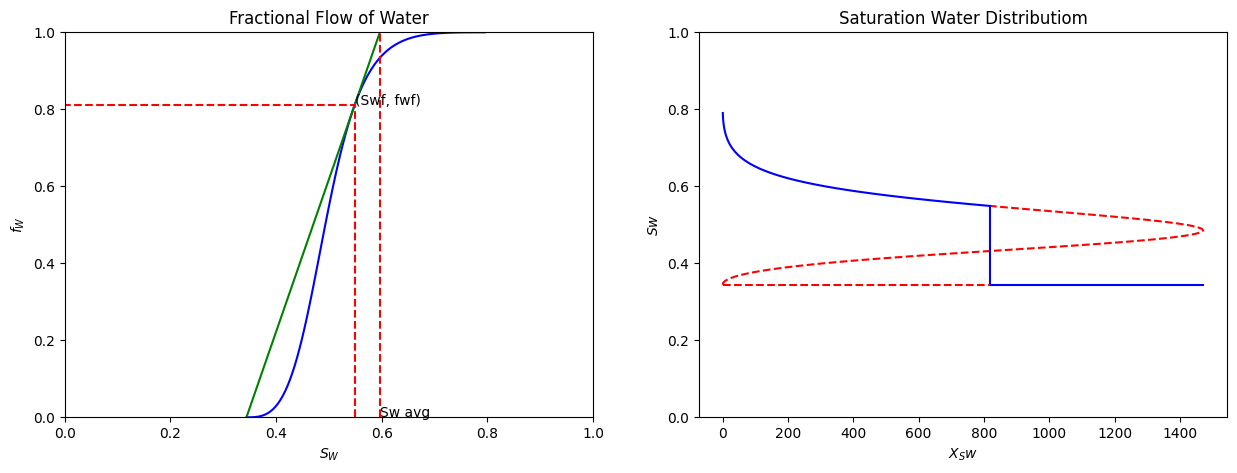

,Condition,time (day),Qi (PV),Oil Rate Prod (bbl/d),Cum Oil Prod (bbl),Water Cut (%),Water-Oil Ratio,Recovery Factor (%)
0,at Breakthrough,444.426020,0.252438,87.195011,206213.673311,81.207972,5.321405,38.481444
1,after Breakthrough,445.113161,0.252829,79.416184,206532.506710,82.884443,5.842638,38.540941
2,after Breakthrough,446.434019,0.253579,72.218265,207145.384717,84.435719,6.424967,38.655310
3,after Breakthrough,448.330014,0.254656,65.574587,208025.126521,85.867546,7.075912,38.819478
4,after Breakthrough,450.748728,0.256030,59.456545,209147.409636,87.186089,7.804019,39.028907


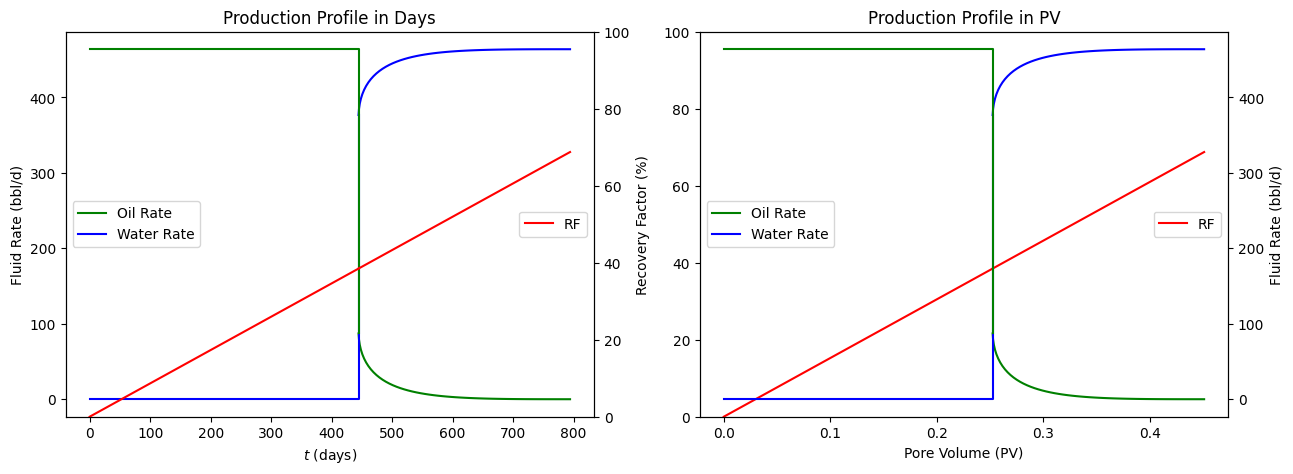

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

"-------------------------------------------------------------------------------------------------"

print('INPUT THE DATA')
print(' ')
print('End-Point Relative Permeability')
Swi = float(input('Swi: '))
Sor = float(input('Sor: '))
krwe = float(input('Krw@1-Sor: '))
kroe = float(input('Kro@Swi: '))
a = float(input('Exponent of Krw: '))
b = float(input('Exponent of Kro: '))
print(' ')
print('Reservoir Properties')
por = float(input('Porosity: '))
width = float(input('Widht, ft: '))
L = float(input('Lenght, ft: '))
h = float(input('Thickness, ft: '))
print(' ')
print('Fluid Properties')
uw = float(input('Water viscosity, cP: '))
uo = float(input('Oil viscosity, cP: '))
print(' ')
qt = float(input('Injection rate, bbl/d: '))

"-------------------------------------------------------------------------------------------------"
Vpore = (width*L*h*por)
Sorw = 1-Sor
Sw = np.linspace(Swi,Sorw,100)

#Initializing Swd
Swd = []
for i in Sw:
  Swd.append((i-Swi)/(1-Sor-Swi))

#Generating Krw
krw = []
for i in Swd:
  krw.append(krwe*(i**a))

#Generating Kro
kro = []
for i in Swd:
  kro.append(kroe*(1-i)**a)

"-------------------------------------------------------------------------------------------------"

#Calculating fw
fw = []
for i, j in zip(krw, kro):
  if i != 0:
    fw.append(1 / (1 + (j / i) * (uw / uo)))
  else:
    fw.append(0)

#Calculating dfw/dSw
dfw_dSw = []
for i in range(len(Sw)):
  if i == 0:
    dfw_dSw.append(0)
  elif (Sw[i] - Swi) != 0 and (Sw[i] - Sw[i-1]) != 0:
    dfw_dSw.append((fw[i] - fw[i-1]) / (Sw[i] - Sw[i-1]))
  else:
    dfw_dSw.append(0)

#Calculating Gradient of fw
gradient_fw = []
for i in range(len(Sw)):
    if Sw[i] - Sw[0] != 0:
      gradient_fw.append((fw[i] - fw[0]) / (Sw[i] - Sw[0]))
    else:
      gradient_fw.append(0)

"-------------------------------------------------------------------------------------------------"

#Breakthrough Condition
for i in range(len(dfw_dSw)-1,0,-1):
    if((gradient_fw[i] - dfw_dSw[i]) <= .0001):
      Swf = Sw[i]
      Swf_index = i
      m_line = gradient_fw[Swf_index]
      Sw_bar = (1 + (Swi*m_line))/m_line
      fwf = fw[Swf_index]
      tBT = (Vpore/qt)*(1/((fwf/(Swf-Swi))))
      break

y = []
for i in range(len(Sw)):
    y.append(m_line*Sw[i] - Swi*m_line)

X = []
for i in range(len(dfw_dSw)):
  X.append(((qt*tBT)/(width*h*por))*dfw_dSw[i])

Xf = X[Swf_index]
Xmax = max(X)
Xmin = min(X)

"-------------------------------------------------------------------------------------------------"

#After Breakthrough Condition
Sw_aBT = Sw[Swf_index:]
fw_aBT = fw[Swf_index:]
m_aBT = gradient_fw[Swf_index:]
Sw_avg = []
for i in range(len(m_aBT)):
  Sw_avg.append((1 + (Swi*m_aBT[i]))/m_aBT[i])
t_aBT = []
for i in range(len(Sw_aBT)):
  t_aBT.append((Vpore)/qt * (1/((fw_aBT[i]/(Sw_aBT[i]-Swi)))))

"-------------------------------------------------------------------------------------------------"

#Calculating Waterflooding Performance
Qi = []
qo = []
qw = []
Np = []
WC = []
WOR = []
RF = []
for i in range(len(t_aBT)):
  Qi.append((qt*t_aBT[i])/Vpore)
  qo.append(qt*(1-fw_aBT[i]))
  qw.append(qt*fw_aBT[i])
  Np.append(Vpore*(Sw_avg[i]-Swi))
  WC.append(fw_aBT[i]*100)
  WOR.append(qt/qo[i])
  RF.append((Np[i])/(Vpore*(1-Swi))*100)

Condition = []
for i in range(len(t_aBT)):
  if t_aBT[i] == tBT:
    Condition.append('at Breakthrough')
  else:
    Condition.append('after Breakthrough')

"-------------------------------------------------------------------------------------------------"

f = plt.figure(figsize=(15, 5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

#Drawing the Sw vs fw Curve
ax.plot(Sw, fw, 'b-')
ax.plot(Sw, y, 'g-')
ax.plot([Swf, Swf, 0], [0, fwf, fwf], 'r--')
ax.plot([Sw_bar, Sw_bar], [0, 1], 'r--')
ax.annotate('(Swf, fwf)', (Swf, fwf))
ax.annotate('Sw avg', (Sw_bar, 0))
ax.set_title('Fractional Flow of Water')
ax.set_xlabel('$S_W$')
ax.set_ylabel('$f_W$')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

#Drawing the Xsw vs Sw Curve
ax2.plot(X[Swf_index:-1], Sw[Swf_index:-1], 'b-')
ax2.plot(X[0:Swf_index+1], Sw[0:Swf_index+1], 'r--')
ax2.plot([Xf, Xf], [Swi, Swf], 'b-')
ax2.plot([Xf, Xmax], [Swi,Swi], 'b-')
ax2.plot([Xmin, Xf], [Swi,Swi], 'r--')
ax2.annotate('(Swf, Xf)', (Swf, Xf))
ax2.set_title('Saturation Water Distributiom')
ax2.set_xlabel('$X_Sw$')
ax2.set_ylabel('$Sw$')
ax2.set_ylim(0, 1)

plt.show()

"-------------------------------------------------------------------------------------------------"

f2 = plt.figure(figsize=(15, 5))
ax3 = f2.add_subplot(121)
ax5 = f2.add_subplot(122)

#Drawing the Production Profile in Time
ax3.plot(t_aBT, qo, 'g-', label='Oil Rate')
ax3.plot(t_aBT, qw, 'b-', label='Water Rate')
ax3.plot([0, t_aBT[0], t_aBT[0]], [0, 0, qw[0]], 'b-')
ax3.plot([0, t_aBT[0], t_aBT[0]], [qt, qt, qo[0]], 'g-')
ax3.set_xlabel('$t$ (days)')
ax3.set_ylabel('Fluid Rate (bbl/d)')
ax3.set_title('Production Profile in Days')
ax3.legend(loc='center left')
ax4 = ax3.twinx()
ax4.plot(t_aBT, RF, 'r-', label='RF')
ax4.plot([0, t_aBT[0]], [0, RF[0]], 'r-')
ax4.set_ylabel('Recovery Factor (%)')
ax4.set_ylim(0, 100)
ax4.legend(loc='center right')

#Drawing the Production Profile in PV
ax5.plot(Qi, RF, 'r-',  label='RF')
ax5.plot([0, Qi[0]], [0, RF[0]], 'r-')
ax5.set_xlabel('Pore Volume (PV)')
ax5.set_ylim(0, 100)
ax5.set_title('Production Profile in PV')
ax5.legend(loc='center right')
ax6 = ax5.twinx()
ax6.plot(Qi, qo, 'g-', label='Oil Rate')
ax6.plot(Qi, qw, 'b-', label='Water Rate')
ax6.plot([0, Qi[0], Qi[0]], [0, 0, qw[0]], 'b-')
ax6.plot([0, Qi[0], Qi[0]], [qt, qt, qo[0]], 'g-')
ax6.set_ylabel('Fluid Rate (bbl/d)')
ax6.legend(loc='center left')

"-------------------------------------------------------------------------------------------------"

production_data = pd.DataFrame((zip(Condition, t_aBT, Qi, qo, Np, WC, WOR, RF)),
               columns =['Condition','time (day)', 'Qi (PV)', 'Oil Rate Prod (bbl/d)', 'Cum Oil Prod (bbl)', 'Water Cut (%)', 'Water-Oil Ratio', 'Recovery Factor (%)'])
production_data.head()